# 不動産の価格を複数の説明変数から予測する

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/real_estate2.xlsx")

In [4]:
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


In [5]:
df["elapsed"] = 2018 - df["year"]

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
df["distance"].unique()

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [7]:
dis_arr = df["distance"].unique()

In [8]:
dis_arr

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [9]:
dis_dict = {dis_arr[0]:10, dis_arr[1]:15, dis_arr[2]:5, dis_arr[3]:20, dis_arr[4]:30, dis_arr[5]:np.nan}

In [10]:
dis_dict

{'徒歩10分以内': 10, '徒歩15分以内': 15, '徒歩5分以内': 5, '徒歩15分超': 20, 'バス': 30, '-': nan}

In [11]:
df["distance2"] = df["distance"].apply(lambda x:dis_dict[x])

In [12]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,35,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,35,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,35,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0


In [13]:
# 欠損行削除

df = df.dropna()

In [14]:
# 数値列のみ使う

df2 = df[["space","elapsed","distance2","value"]]

In [15]:
df2.head()

,space,elapsed,distance2,value
0,70,35,10.0,910
1,70,35,10.0,1120
2,70,35,10.0,1190
3,70,35,10.0,1190
4,70,35,10.0,1190


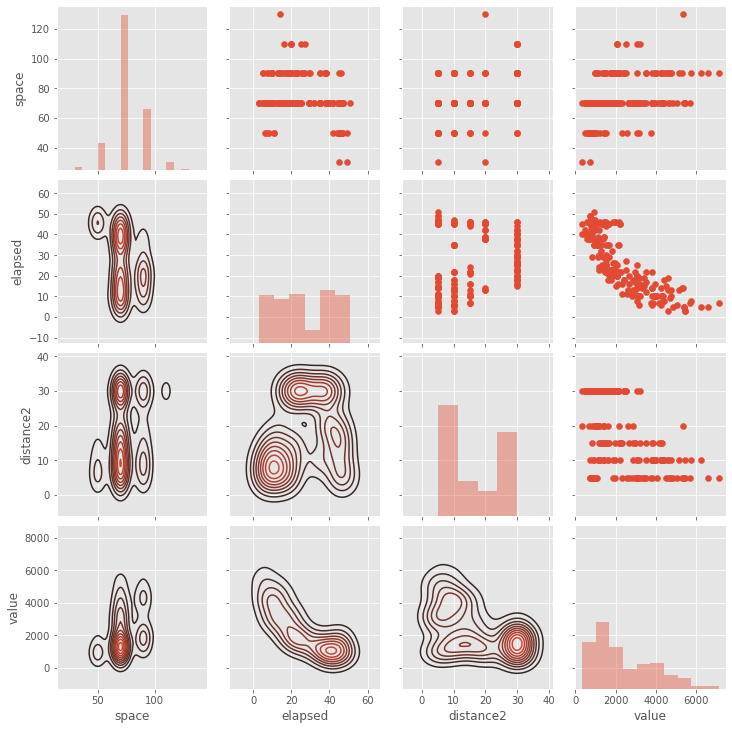

In [16]:
# 築年数が価格に強く影響する

g = sns.PairGrid(df2)
g = g.map_lower(sns.kdeplot)  # 左下の要素は等高線
g = g.map_diag(sns.distplot, kde=False)  # 対角成分はカーネル密度推定なしのヒストグラム
g = g.map_upper(plt.scatter)   # 右上の要素は散布図

In [17]:
# 物件価格は
# 駅からの距離
# 部屋の大きさ
# 築年数 の線形結合で表せるとする
# 予測値のヒストグラムは正規分布すると仮定する

stan_model = """
data {
  int N;
  real elapsed[N];
  real dis[N];
  real space[N];
  real Y[N];
}

parameters {
  real d;
  real s;
  real e;
  real b;
  real<lower=0> sigma;
}

model {
  real mu;
  for (n in 1:N){
    mu = e * elapsed[n] + d * dis[n] + s * space[n] + b;
    Y[n] ~ normal(mu, sigma);
  }
}

"""

In [18]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aaf2e8dabdfaaa9b3e5a603a25c838cc NOW.


In [19]:
stan_data = {"N":df.shape[0],"elapsed":df["elapsed"],"dis":df["distance2"], "space":df["space"], "Y":df["value"]}

In [20]:
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=4, seed=123)

In [21]:
fit

Inference for Stan model: anon_model_aaf2e8dabdfaaa9b3e5a603a25c838cc.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d     -57.56    0.08   4.98 -67.42 -60.88 -57.49 -54.21 -47.86   3857    1.0
s      24.62    0.07   3.59  17.44  22.19  24.55  26.99  31.65   2774    1.0
e     -67.68    0.06   3.74 -75.06 -70.21 -67.72 -65.17 -60.36   3392    1.0
b     3299.3    5.71 294.14 2734.2 3100.8 3304.8 3497.2 3885.9   2653    1.0
sigma 636.87    0.44  31.74 577.41 615.03 635.19 657.69 701.32   5111    1.0
lp__   -1363    0.03   1.54  -1367  -1364  -1363  -1362  -1361   2142    1.0

Samples were drawn using NUTS at Wed Sep 30 10:56:51 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

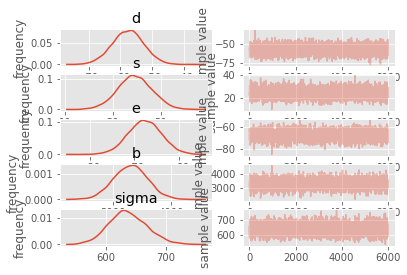

In [22]:
fig = fit.plot()